# will they or won't they?

a simple machine learning model for predicting whether a user makes a prime day purchase, based off their captured behavior and whether they are an amazon user or not.

In [48]:
import duckdb
from   imblearn.ensemble import BalancedBaggingClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from   sklearn.compose import ColumnTransformer
from   sklearn.ensemble import RandomForestClassifier
from   sklearn.linear_model import LogisticRegression
from   sklearn.metrics import (
            classification_report, confusion_matrix, accuracy_score,
            precision_recall_curve, roc_curve, roc_auc_score,
            precision_score, recall_score, f1_score, average_precision_score
        )
from   sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from   sklearn.pipeline import Pipeline
from   sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import xgboost as xgb
import warnings


In [2]:
# configs
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
DATABASE_FILEPATH='../data/prime.ddb'

# a processing pipeline:
+ filter out numerical features
    - scale and standardise numerical features
+ (also be ready to handle categorical features)
    - one-hot-encode categorical features
+ split data set into test data and training data
+ train models on training data:
    - logistic regression: baseline
    - random forest: a steady go-to, flexible
    - xgboost: the usual king-of-the hill classifier model
+ compute evaluation metrics
    + precision
    + recall
    + accuracy
    + f1
+ results and interpretation

In [50]:
class PurchasePredictionPipeline:
    """
    a pipeline for predicting, from mixed categorical and numerical data, whether user made a purchase on prime day.
    """
    
    def __init__(self):
        self.models = {}
        self.preprocessor = None
        self.feature_names = None
        
    def create_preprocessor(self, X):
        """
        a preprocessing pipeline for mixed data types
        """
        
        # identify and separate out numerical and categorical columns
        numerical_features = X.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()
        categorical_features = X.select_dtypes(include=['object','category']).columns.tolist() # none at present
        
        print(f"numerical features: {numerical_features}")
        print(f"categorical features: {categorical_features}")
        
        # preprocessing steps
        numerical_transformer = StandardScaler()
        categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)
        
        # combine preprocessing steps
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ]
        )
        
        return preprocessor


    def _get_feature_names(self, X):
        """
        feature names after preprocessing
        """
        feature_names = []
        
        # numerical features
        numerical_features = X.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()
        feature_names.extend(numerical_features)
        
        # categorical features (after one-hot encoding)
        categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
        for col in categorical_features:
            unique_values = X[col].unique()
            # one hot encoder drops first category
            for val in sorted(unique_values)[1:]:
                feature_names.append(f"{col}_{val}")
        
        return feature_names

    def prepare_data(self, df, target_col='is_purchaser', test_size=0.2, random_state=42):
        """
        convert dataframe into training data shape, and split up testing/training data
        """
        
        # separate features and target
        X = df.drop(columns=[target_col])
        y = df[target_col]
        
        # separate out training data and testing data with random selection
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        # preprocessor on all data 
        # (note the harmless leakage! test data is allowed to influence scaler ranges)
        self.preprocessor = self.create_preprocessor(X)
        
        # transform the data in scaled 
        X_train_processed = self.preprocessor.fit_transform(X_train)
        X_test_processed = self.preprocessor.transform(X_test)
        
        # store feature names in object data for later use
        self.feature_names = self._get_feature_names(X)
        
        return X_train_processed, X_test_processed, y_train, y_test
    
    
    def build_logistic_regression(self, X_train, y_train):
        """
        baseline model: logistic regression
        """
        
        print("\n" + "="*50)
        print("LOGISTIC REGRESSION")
        print("="*50)
        
        model = LogisticRegression(
            random_state=42,
            max_iter=1000,
            class_weight='balanced'  # class imbalance
        )
        
        model.fit(X_train, y_train)
        self.models['logistic_regression'] = model
        
        print("✓ logistic regression model trained")
        return model
    
    def build_random_forest(self, X_train, y_train):
        """
        comparison model no 1:  random forest
        """
        
        print("\n" + "="*50)
        print("RANDOM FOREST")
        print("="*50)
        
        model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        )
        
        model.fit(X_train, y_train)
        self.models['random_forest'] = model
        
        print("✓ random forest model trained")
        return model


    def build_balanced_bagging_classifier(self, X_train, y_train):
        """
        comparison model no 2:  balanced bagging
        """
        
        print("\n" + "="*50)
        print("BALANCED BAGGING")
        print("="*50)

        model = BalancedBaggingClassifier(
            base_classifier,
            sampling_strategy='auto',  # adjust this parameter
            replacement=False,  # sample with or without replacement
            random_state=42
        )
        
        model.fit(X_train, y_train)
        self.models['balanced_bagging'] = model
        
        print("✓ balanced bagging model trained")
        return model


        
    def build_xgboost(self, X_train, y_train):
        """
        comparison model no 3: XGBoost
        """
        
        print("\n" + "="*50)
        print("XGBOOST")
        print("="*50)
        
        # calculate scale pos weights for class imbalance
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        
        model = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            eval_metric='logloss',
            n_jobs=-1
        )
        
        model.fit(X_train, y_train)
        self.models['xgboost'] = model
        
        print("✓ XGBoost model trained")
        return model
    
    def get_feature_importance(self, model_name):
        """
        feature importance reporting for tree-based models
        """
        
        if model_name not in self.models:
            print(f"model {model_name} not found!")
            return None
        
        model = self.models[model_name]
        
        if model_name == 'random_forest':
            importance = model.feature_importances_
        elif model_name == 'balanced_bagging':
            importance = model.feature_importances_
        elif model_name == 'xgboost':
            importance = model.feature_importances_
        else:
            print(f"feature importance not available for {model_name}")
            return None
        
        # feature importance dataframe
        feature_importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        return feature_importance_df
    
    def train_all_models(self, df):
        """
        run pipeline and train all models
        """
        
        print("STARTING TRAINING PIPELINE")
        print("="*50)
        
        # prepare data
        X_train, X_test, y_train, y_test = self.prepare_data(df)
        
        print(f"\nshape of training data: {X_train.shape}")
        print(f"shape of test data: {X_test.shape}")
        print(f"number of features after preprocessing: {X_train.shape[1]}")
        
        # train all models
        self.build_logistic_regression(X_train, y_train)
        self.build_random_forest(X_train, y_train)
        self.build_balanced_bagging_classifier(X_train, y_train)
        self.build_xgboost(X_train, y_train)
        
        print(f"\n" + "="*50)
        print("ALL MODELS TRAINED")
        print(f"models available: {list(self.models.keys())}")
        print("="*50)
        return X_train, X_test, y_train, y_test


In [51]:
class ModelEvaluator:
    """
    evaluation class for classification models
    """
    
    def __init__(self, models, X_train, X_test, y_train, y_test, feature_names=None):
        self.models = models
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.feature_names = feature_names or [f'feature_{i}' for i in range(X_train.shape[1])]
        self.predictions = {}
        self.probabilities = {}
        self.metrics = {}
    
    
    def generate_predictions(self):
        """
        predictions and probabilities for all models
        """
        
        print("="*50)
        print("INFERRING PREDICTIONS FROM ALL MODELS")
        print("="*50)
        
        for name, model in self.models.items():
            # predict the class
            y_pred = model.predict(self.X_test)
            y_pred_proba = model.predict_proba(self.X_test)[:, 1]  # probability of positive class
            
            self.predictions[name] = y_pred
            self.probabilities[name] = y_pred_proba
            
            print(f"✓ inferred predictions for {name}")
        
        print("predictions generated\n")
    
    def calculate_metrics(self):
        """
        comprehensive metrics for all models
        """
        
        print("="*50)
        print("PERFORMANCE METRICS")
        print("="*50)
        
        metrics_data = []
        
        for name in self.models.keys():
            y_pred = self.predictions[name]
            y_pred_proba = self.probabilities[name]
            
            # model quality metrics
            accuracy = accuracy_score(self.y_test, y_pred)                 # do not use on imbalanced data sets
            precision = precision_score(self.y_test, y_pred)               # how many predicted to purchase, actually did purchase?
            recall = recall_score(self.y_test, y_pred)                     # how many actually purchasing were predicted to do so?
            f1 = f1_score(self.y_test, y_pred)                             # a balance of precision and recall
            auc_roc = roc_auc_score(self.y_test, y_pred_proba)             # area under receiver-operator curve
            auc_pr = average_precision_score(self.y_test, y_pred_proba)    # average precision score
            
            metrics_data.append({
                'model': name,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1-score': f1,
                'ROC-AUC': auc_roc,
                'PR-AUC': auc_pr
            })
            
            self.metrics[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'roc_auc': auc_roc,
                'pr_auc': auc_pr
            }
        
        self.metrics_df = pd.DataFrame(metrics_data)
        
        print("all metrics calculated\n")
        return self.metrics_df
    
    def cross_validation_scores(self, cv_folds=8):
        """
        cross-validation score for models
        """
        
        print("="*50)
        print("CROSS-VALIDATION")
        print("="*50)
        
        cv_results = {}
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        
        # combine train and test sets for CV
        X_full = np.vstack([self.X_train, self.X_test])
        y_full = np.hstack([self.y_train, self.y_test])
        
        for name, model in self.models.items():
            # perform cross-validation for multiple metrics
            cv_accuracy  = cross_val_score(model, X_full, y_full, cv=skf, scoring='accuracy')
            cv_recall    = cross_val_score(model, X_full, y_full, cv=skf, scoring='recall')
            cv_precision = cross_val_score(model, X_full, y_full, cv=skf, scoring='precision')
            cv_f1        = cross_val_score(model, X_full, y_full, cv=skf, scoring='f1')
            cv_roc_auc   = cross_val_score(model, X_full, y_full, cv=skf, scoring='roc_auc')
            
            cv_results[name] = {
                'accuracy_mean':  cv_accuracy.mean(),
                'accuracy_std':   cv_accuracy.std(),
                'precision_mean': cv_precision.mean(),
                'precision_std':  cv_precision.std(),
                'recall_mean':    cv_recall.mean(),
                'recall_std':     cv_recall.std(),
                'f1_mean':        cv_f1.mean(),
                'f1_std':         cv_f1.std(),
                'roc_auc_mean':   cv_roc_auc.mean(),
                'roc_auc_std':    cv_roc_auc.std()
            }
            
            print(f"{name}:")
            print(f"   accuracy: {cv_accuracy.mean():.4f}  (±{cv_accuracy.std():.4f})")
            print(f"  precision: {cv_precision.mean():.4f} (±{cv_precision.std():.4f})")
            print(f"     recall: {cv_recall.mean():.4f}    (±{cv_recall.std():.4f})")
            print(f"   f1-Score: {cv_f1.mean():.4f}        (±{cv_f1.std():.4f})")
            print(f"    ROC-AUC: {cv_roc_auc.mean():.4f}   (±{cv_roc_auc.std():.4f})")
        
        self.cv_results = cv_results
        return cv_results
    
    def plot_confusion_matrices(self):
        """
        confusion matrices for all models
        """
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle('confusion matrices comparison', fontsize=16, fontweight='bold')
        
        for idx, (name, y_pred) in enumerate(self.predictions.items()):
            cm = confusion_matrix(self.y_test, y_pred)
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['no purchase', 'purchase'],
                       yticklabels=['no purchase', 'purchase'],
                       ax=axes[idx])
            
            axes[idx].set_title(f'{name.replace("_", " ").title()}')
            axes[idx].set_xlabel('predicted')
            axes[idx].set_ylabel('actual')
        
        plt.tight_layout()
        plt.show()
    
    def plot_roc_curves(self):
        """
        plot ROC curves
        """
        
        plt.figure(figsize=(10, 8))
        
        for name, y_pred_proba in self.probabilities.items():
            fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
            auc_score = roc_auc_score(self.y_test, y_pred_proba)
            
            plt.plot(fpr, tpr, linewidth=2, 
                    label=f'{name.replace("_", " ").title()} (AUC = {auc_score:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='random classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('false positive rate', fontsize=12)
        plt.ylabel('true positive rate', fontsize=12)
        plt.title('ROC comparison', fontsize=14, fontweight='bold')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def plot_precision_recall_curves(self):
        """
        plotting precision-recall curves
        """
        
        plt.figure(figsize=(10, 8))
        
        for name, y_pred_proba in self.probabilities.items():
            precision, recall, _ = precision_recall_curve(self.y_test, y_pred_proba)
            avg_precision = average_precision_score(self.y_test, y_pred_proba)
            
            plt.plot(recall, precision, linewidth=2,
                    label=f'{name.replace("_", " ").title()} (AP = {avg_precision:.3f})')
        
        # Baseline (random classifier)
        baseline = (self.y_test == 1).mean()
        plt.axhline(y=baseline, color='k', linestyle='--', linewidth=1, 
                   label=f'random classifier (AP = {baseline:.3f})')
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('recall', fontsize=12)
        plt.ylabel('precision', fontsize=12)
        plt.title('precision-recall curves', fontsize=14, fontweight='bold')
        plt.legend(loc="lower left")
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def plot_feature_importance_comparison(self):
        """
        compare feature importance across tree-based models
        """
        
        tree_models = ['random_forest', 'xgboost']
        available_models = [name for name in tree_models if name in self.models.keys()]
        
        if len(available_models) < 2:
            print("need at least 2 tree-based models for comparison")
            return
        
        fig, axes = plt.subplots(1, len(available_models), figsize=(6*len(available_models), 8))
        if len(available_models) == 1:
            axes = [axes]
        
        for idx, model_name in enumerate(available_models):
            model = self.models[model_name]
            importance = model.feature_importances_
            
            # feature importance dataframe
            feature_importance_df = pd.DataFrame({
                'feature': self.feature_names,
                'importance': importance
            }).sort_values('importance', ascending=True)
            
            # horizontal bar chart
            axes[idx].barh(range(len(feature_importance_df)), 
                          feature_importance_df['importance'])
            axes[idx].set_yticks(range(len(feature_importance_df)))
            axes[idx].set_yticklabels(feature_importance_df['feature'])
            axes[idx].set_xlabel('feature importance')
            axes[idx].set_title(f'{model_name.replace("_", " ").title()}\nfeature importance')
            axes[idx].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_prediction_confidence(self):
        """
        analyze prediction confidence distributions
        """
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle('prediction confidence distributions', fontsize=16, fontweight='bold')
        
        for idx, (name, probabilities) in enumerate(self.probabilities.items()):
            # separate probabilities by actual class
            prob_no_purchase = probabilities[self.y_test == 0]
            prob_purchase = probabilities[self.y_test == 1]
            
            axes[idx].hist(prob_no_purchase, bins=30, alpha=0.7, 
                          label='no purchase (actual)', color='lightcoral')
            axes[idx].hist(prob_purchase, bins=30, alpha=0.7, 
                          label='purchase (actual)', color='lightblue')
            
            axes[idx].set_xlabel('predicted probability of purchase')
            axes[idx].set_ylabel('frequency')
            axes[idx].set_title(f'{name.replace("_", " ").title()}')
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def generate_detailed_report(self):
        """
        model evaluation report
        """
        
        print("\n" + "="*50)
        print("MODEL EVALUATION REPORT")
        print("="*50)
        
        # metrics comparison
        print("\n1. PERFORMANCE METRICS COMPARISON")
        print("-"*50)
        print(self.metrics_df.round(4).to_string(index=False))
        
        # Best model identification
        print(f"\n2. BEST MODEL BY METRIC")
        print("-"*50)
        for metric in ['accuracy', 'precision', 'recall', 'f1-score', 'ROC-AUC', 'PR-AUC']:
            best_model = self.metrics_df.loc[self.metrics_df[metric].idxmax(), 'model']
            best_score = self.metrics_df[metric].max()
            print(f"{metric:12}: {best_model:15} ({best_score:.4f})")
        
        # cross-validation results
        if hasattr(self, 'cv_results'):
            print(f"\n3. CROSS-VALIDATION RESULTS ({5}-FOLD)")
            print("-"*50)
            for name, results in self.cv_results.items():
                print(f"\n{name.replace('_', ' ').title()}:")
                print(f"  accuracy: {results['accuracy_mean']:.4f} (±{results['accuracy_std']:.4f})")
                print(f"  f1-score: {results['f1_mean']:.4f} (±{results['f1_std']:.4f})")
                print(f"  ROC-AUC:  {results['roc_auc_mean']:.4f} (±{results['roc_auc_std']:.4f})")
        
        # feature importance insights for tree models
        print(f"\n4. KEY INSIGHTS FROM FEATURE IMPORTANCE")
        print("-"*50)
        
        tree_models = ['random_forest', 'xgboost']
        for model_name in tree_models:
            if model_name in self.models:
                model = self.models[model_name]
                importance = model.feature_importances_
                
                # Get top 3 features
                top_indices = np.argsort(importance)[-3:][::-1]
                
                print(f"\n{model_name.replace('_', ' ').title()} - top 3 features:")
                for i, idx in enumerate(top_indices, 1):
                    print(f"  {i}. {self.feature_names[idx]}: {importance[idx]:.4f}")
        
        # model recommendations
        print(f"\n5. MODEL RECOMMENDATIONS")
        print("-"*50)
        
        # Find overall best model (weighted average of key metrics)
        weights = {'f1-score': 0.3, 'ROC-AUC': 0.3, 'PR-AUC': 0.25, 'precision': 0.15}
        weighted_scores = {}
        
        for _, row in self.metrics_df.iterrows():
            model_name = row['model']
            weighted_score = sum(row[metric] * weight for metric, weight in weights.items())
            weighted_scores[model_name] = weighted_score
        
        best_overall = max(weighted_scores.keys(), key=lambda x: weighted_scores[x])
        
        print(f"\noverall best model: {best_overall.replace('_', ' ').title()}")
        print(f"weighted score: {weighted_scores[best_overall]:.4f}")
        
        print(f"\nmodel-specific insights:")
        print(f"• logistic regression: baseline, interpretable coefficients")
        print(f"• random forest: handles feature interactions, feature type diversity, robust to outliers")
        print(f"• XGBoost: often best performance, handles imbalanced data well")
        
        print("\n"+"="*50)
    
    def run_complete_evaluation(self):
        """run the complete evaluation pipeline."""
        
        print("="*50)
        print("STARTING MODEL EVALUATION")
        print("="*50)
        
        # generate predictions
        self.generate_predictions()
        
        # compute metrics
        self.calculate_metrics()
        
        # cross-validation
        self.cross_validation_scores()
        
        # generate plots
        print("VISUALIZATION PLOTS")
        print("="*50)
        
        self.plot_confusion_matrices()
        self.plot_roc_curves()
        self.plot_precision_recall_curves()
        self.plot_feature_importance_comparison()
        self.analyze_prediction_confidence()
        
        # generate comprehensive report
        self.generate_detailed_report()
        
        return self.metrics_df

# fetch data from database

the training data has been prepared in the database. we will need to drop some columns from that data table:
- we cannot use the `user_id` column unique per observation and has no bearing on whether someone makes a purchase or not
- and it turns out that the `is_amazon_user` just gives the game away, so let's try fitting a model without it
- column `num_apps` is uniformly 1, so useless. drop that.
- columns 
- columns `num_countries`, `num_genders`, `num_age_groups` are just for sanity checking and are uniformly unity.
- i don't have time now to feature engineer the search terms into usuable features so leaving `all_searches_combined` out for now
- we're only going to predict whether a purchase was made or not. hence drop other purchase-related metrics:
    + `num_successful_orders`
    + `total_spend`
    + `num_categories_purchased`
    + `num_subcategories_purchased`
    + `num_brands_purchased`

(TODO: add boolean features and feature engineering based on natural languave processing of the search terms).

In [52]:
with duckdb.connect(DATABASE_FILEPATH) as con:
    df=(
        con.sql("SELECT * FROM training_data")
        .df()
        .drop(
            columns=[
                'user_id',                     ## this field should have no bearing on the outcome
                'is_amazon_user',              ## this gives the game away, it turns out
                'num_apps',                    ## uniformly 1
                'num_countries',               ## uniformly 1
                'country',                     ## uniformly 'US'
                'num_genders',                 ## uniformly 1
                'num_age_groups',              ## uniformly 1
                'earliest_event',              ## not using datetime fields at present
                'latest_event',                ## not using datetime fields at present
                'all_searches_combined',       ## not using nlp fields at present
                'num_successful_orders',       ## an outcome field for regression models, later
                'total_spend',                 ## an outcome field for regression models, later
                'num_categories_purchased',    ## an outcome field for regression models, later
                'num_subcategories_purchased', ## an outcome field for regression models, later
                'num_brands_purchased'         ## an outcome field for regression models, later
            ]
        )
    )

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   num_events          993 non-null    int64   
 1   num_event_types     993 non-null    int64   
 2   num_domains         993 non-null    int64   
 3   range_active_days   993 non-null    int64   
 4   num_dates_active    993 non-null    int64   
 5   prop_top_domains    993 non-null    float32 
 6   prop_rare_domains   993 non-null    float32 
 7   prop_search_events  993 non-null    float32 
 8   gender              993 non-null    category
 9   age_group           993 non-null    category
 10  is_purchaser        993 non-null    bool    
dtypes: bool(1), category(2), float32(3), int64(5)
memory usage: 54.0 KB


In [19]:
display(df.head())

,num_events,num_event_types,num_domains,range_active_days,num_dates_active,prop_top_domains,prop_rare_domains,prop_search_events,gender,age_group,is_purchaser
0,236,2,46,6,6,0.254237,0.745763,1.0,female,25_34,True
1,1059,2,153,6,7,0.103872,0.896128,1.0,female,over_64,True
2,1941,2,126,6,6,0.647604,0.352396,1.0,male,35_44,True
3,22,2,4,0,1,0.863636,0.136364,1.0,female,35_44,True
4,222,2,38,5,6,0.117117,0.882883,1.0,non_binary,25_34,True


In [20]:
print(df.dtypes)

num_events               int64
num_event_types          int64
num_domains              int64
range_active_days        int64
num_dates_active         int64
prop_top_domains       float32
prop_rare_domains      float32
prop_search_events     float32
gender                category
age_group             category
is_purchaser              bool
dtype: object


In [26]:
df.columns

Index(['num_events', 'num_event_types', 'num_domains', 'range_active_days',
       'num_dates_active', 'prop_top_domains', 'prop_rare_domains',
       'prop_search_events', 'gender', 'age_group', 'is_purchaser'],
      dtype='object')

In [27]:
print("dataset overview:")
print(f"Shape: {df.shape}")
print(df['is_purchaser'].value_counts(normalize=True))

dataset overview:
Shape: (993, 11)
is_purchaser
False    0.510574
True     0.489426
Name: proportion, dtype: float64


In [28]:
# initialize pipeline process
pipeline = PurchasePredictionPipeline()
# run pipeline
X_train, X_test, y_train, y_test = pipeline.train_all_models(df)

STARTING TRAINING PIPELINE
numerical features: ['num_events', 'num_event_types', 'num_domains', 'range_active_days', 'num_dates_active']
categorical features: ['gender', 'age_group']

shape of training data: (794, 14)
shape of test data: (199, 14)
number of features after preprocessing: 14

LOGISTIC REGRESSION
✓ logistic regression model trained

RANDOM FOREST
✓ random forest model trained

XGBOOST
✓ XGBoost model trained

ALL MODELS TRAINED
models available: ['logistic_regression', 'random_forest', 'xgboost']


In [29]:
pipeline.models

{'logistic_regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
 'random_forest': RandomForestClassifier(class_weight='balanced', max_depth=10,
                        min_samples_leaf=2, min_samples_split=5, n_jobs=-1,
                        random_state=42),
 'xgboost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               

# model evaluation 
1. models are trained and stored in a `pipeline.models` dictionary
2. update the `feature_names` list with actual feature names
3. initialize the `ModelEvaluator()` class with models and data
4. run `evaluator.run_complete_evaluation()`, saving results to df 

In [30]:
X_train.shape

(794, 14)

In [32]:
# display feature importance for tree-based models
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

for model_name in ['random_forest', 'xgboost']:
    print(f"\n{model_name.upper()} - most important features:")
    importance_df = pipeline.get_feature_importance(model_name)
    if importance_df is not None:
        display(importance_df.head(5))



FEATURE IMPORTANCE ANALYSIS

RANDOM_FOREST - most important features:


,feature,importance
0,num_events,0.312724
2,num_domains,0.258771
4,num_dates_active,0.092587
3,range_active_days,0.079845
1,num_event_types,0.052581



XGBOOST - most important features:


,feature,importance
8,age_group_18_24,0.156198
2,num_domains,0.082571
0,num_events,0.081409
12,age_group_55_64,0.075842
4,num_dates_active,0.074826



MODEL BUILDING COMPLETE!


STARTING MODEL EVALUATION
INFERRING PREDICTIONS FROM ALL MODELS
✓ inferred predictions for logistic_regression
✓ inferred predictions for random_forest
✓ inferred predictions for xgboost
predictions generated

PERFORMANCE METRICS
all metrics calculated

CROSS-VALIDATION
logistic_regression:
  accuracy: 0.5840 (±0.0381)
  f1-Score: 0.5825 (±0.0337)
  ROC-AUC:  0.6208 (±0.0303)
random_forest:
  accuracy: 0.5891 (±0.0300)
  f1-Score: 0.5697 (±0.0471)
  ROC-AUC:  0.6150 (±0.0447)
xgboost:
  accuracy: 0.5810 (±0.0215)
  f1-Score: 0.5708 (±0.0365)
  ROC-AUC:  0.5936 (±0.0265)
VISUALIZATION PLOTS


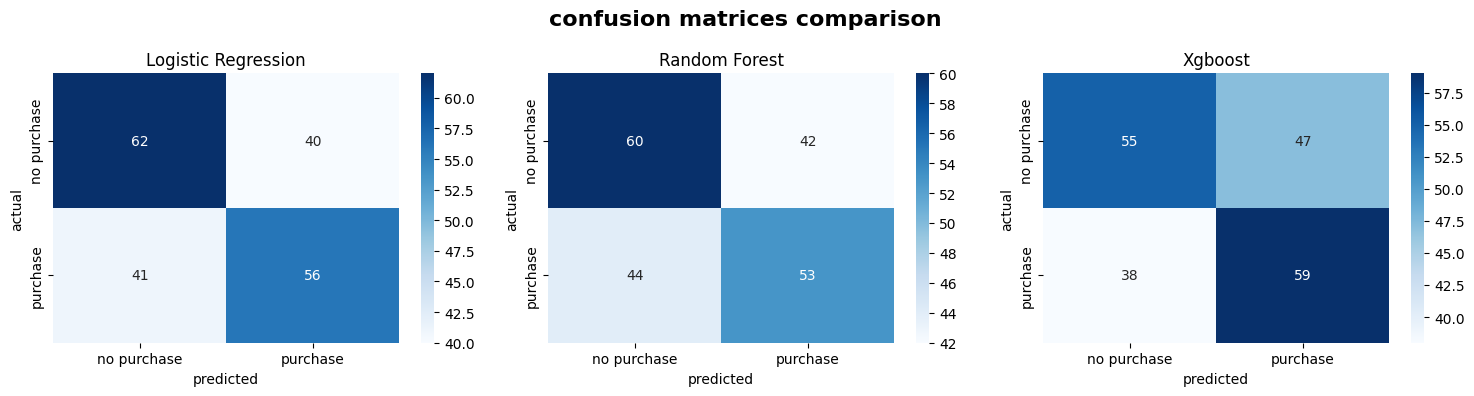

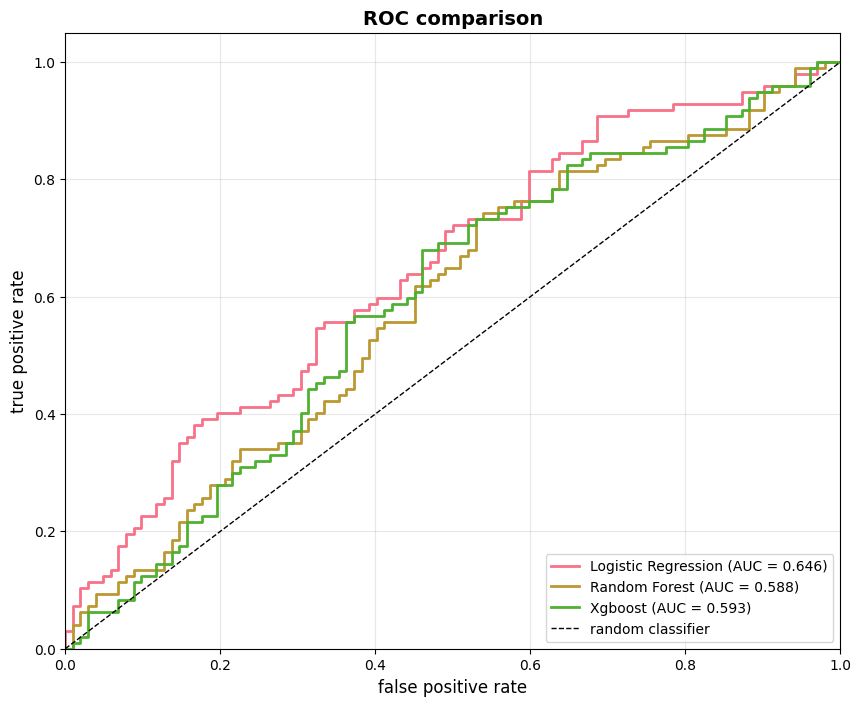

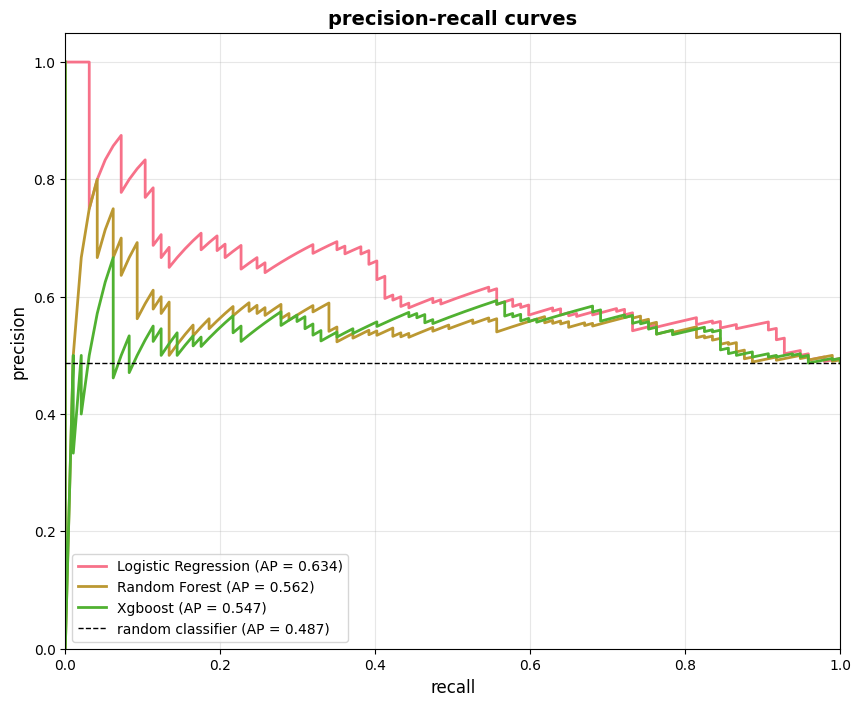

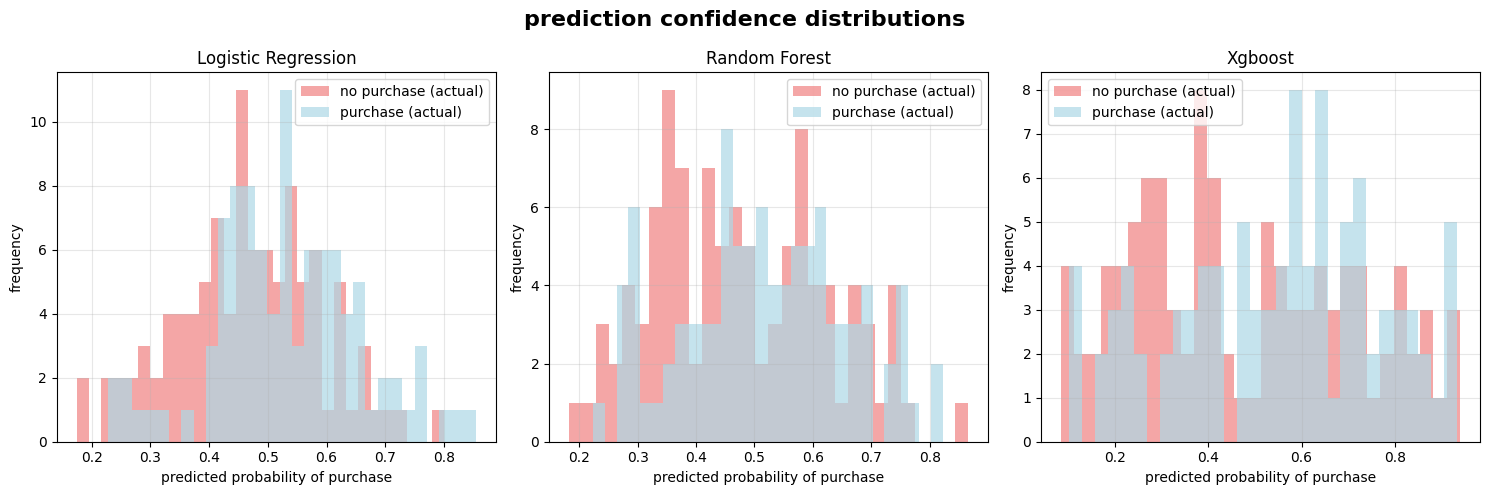


MODEL EVALUATION REPORT

1. PERFORMANCE METRICS COMPARISON
--------------------------------------------------
              model  accuracy  precision  recall  f1-score  ROC-AUC  PR-AUC
logistic_regression    0.5930     0.5833  0.5773    0.5803   0.6457  0.6342
      random_forest    0.5678     0.5579  0.5464    0.5521   0.5884  0.5618
            xgboost    0.5729     0.5566  0.6082    0.5813   0.5926  0.5472

2. BEST MODEL BY METRIC
--------------------------------------------------
accuracy    : logistic_regression (0.5930)
precision   : logistic_regression (0.5833)
recall      : xgboost         (0.6082)
f1-score    : xgboost         (0.5813)
ROC-AUC     : logistic_regression (0.6457)
PR-AUC      : logistic_regression (0.6342)

3. CROSS-VALIDATION RESULTS (5-FOLD)
--------------------------------------------------

Logistic Regression:
  accuracy: 0.5840 (±0.0381)
  f1-score: 0.5825 (±0.0337)
  ROC-AUC:  0.6208 (±0.0303)

Random Forest:
  accuracy: 0.5891 (±0.0300)
  f1-score: 0.56

In [31]:
feature_names = [
    'num_events',
    'num_event_types',
    'num_domains',
    'range_active_days',
    'num_dates_active',
    'prop_top_domains',
    'prop_rare_domains',
    'prop_search_events',
    # 'gender_1',
    'gender_2',
    'gender_3',
    'gender_4',
    # 'age_group_1',
    'age_group_2',
    'age_group_3',
    'age_group_4',
    # 'age_group_5',
    # 'age_group_6',
    # 'age_group_7',
]

# initialize evaluator
evaluator = ModelEvaluator(
    models=pipeline.models,  
    X_train=X_train,
    X_test=X_test, 
    y_train=y_train,
    y_test=y_test,
    feature_names=feature_names
)

# evaluation
results_df = evaluator.run_complete_evaluation()

In [38]:
with duckdb.connect(DATABASE_FILEPATH) as con:
    df=(
        con.sql("SELECT * FROM training_data")
        .df()
        .drop(
            columns=[
                'user_id',                     ## this field should have no bearing on the outcome
                # 'is_amazon_user',      ## this time leave it in! 
                'num_apps',                    ## uniformly 1
                'num_countries',               ## uniformly 1
                'country',                     ## uniformly 'US'
                'num_genders',                 ## uniformly 1
                'num_age_groups',              ## uniformly 1
                'earliest_event',              ## not using datetime fields at present
                'latest_event',                ## not using datetime fields at present
                'all_searches_combined',       ## not using nlp fields at present
                'num_successful_orders',       ## an outcome field for regression models, later
                'total_spend',                 ## an outcome field for regression models, later
                'num_categories_purchased',    ## an outcome field for regression models, later
                'num_subcategories_purchased', ## an outcome field for regression models, later
                'num_brands_purchased'         ## an outcome field for regression models, later
            ]
        )
    )

In [39]:
# initialize pipeline process
pipeline = PurchasePredictionPipeline()
# run pipeline
X_train, X_test, y_train, y_test = pipeline.train_all_models(df)

STARTING TRAINING PIPELINE
numerical features: ['is_amazon_user', 'num_events', 'num_event_types', 'num_domains', 'range_active_days', 'num_dates_active']
categorical features: ['gender', 'age_group']

shape of training data: (794, 15)
shape of test data: (199, 15)
number of features after preprocessing: 15

LOGISTIC REGRESSION
✓ logistic regression model trained

RANDOM FOREST
✓ random forest model trained

XGBOOST
✓ XGBoost model trained

ALL MODELS TRAINED
models available: ['logistic_regression', 'random_forest', 'xgboost']


In [40]:
df.columns

Index(['is_amazon_user', 'num_events', 'num_event_types', 'num_domains',
       'range_active_days', 'num_dates_active', 'prop_top_domains',
       'prop_rare_domains', 'prop_search_events', 'gender', 'age_group',
       'is_purchaser'],
      dtype='object')

STARTING MODEL EVALUATION
INFERRING PREDICTIONS FROM ALL MODELS
✓ inferred predictions for logistic_regression
✓ inferred predictions for random_forest
✓ inferred predictions for xgboost
predictions generated

PERFORMANCE METRICS
all metrics calculated

CROSS-VALIDATION
logistic_regression:
  accuracy: 0.9929 (±0.0076)
  f1-Score: 0.9929 (±0.0076)
  ROC-AUC:  0.9953 (±0.0068)
random_forest:
  accuracy: 0.9929 (±0.0076)
  f1-Score: 0.9929 (±0.0076)
  ROC-AUC:  0.9943 (±0.0071)
xgboost:
  accuracy: 0.9929 (±0.0076)
  f1-Score: 0.9929 (±0.0076)
  ROC-AUC:  0.9957 (±0.0075)
VISUALIZATION PLOTS


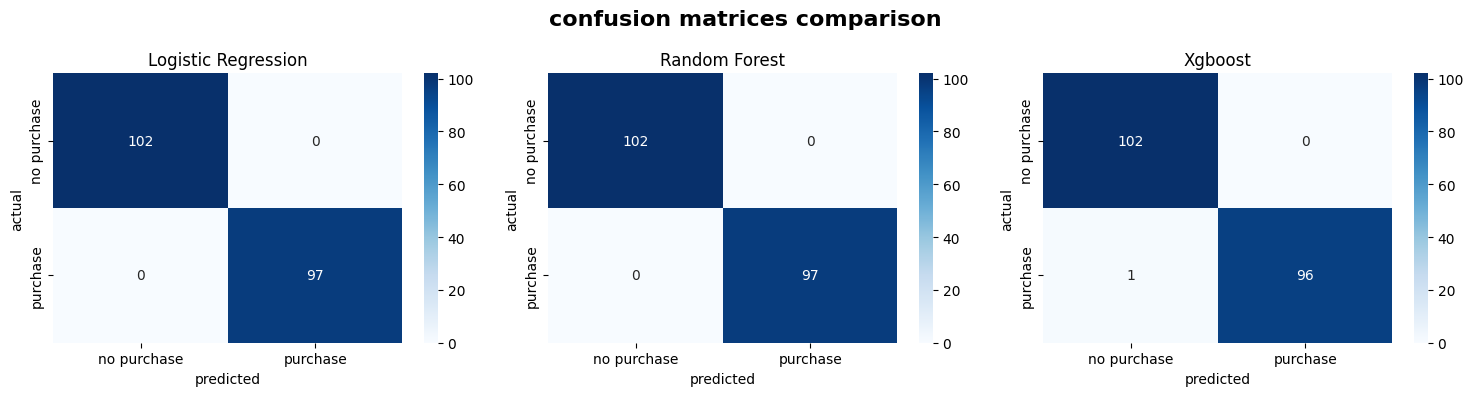

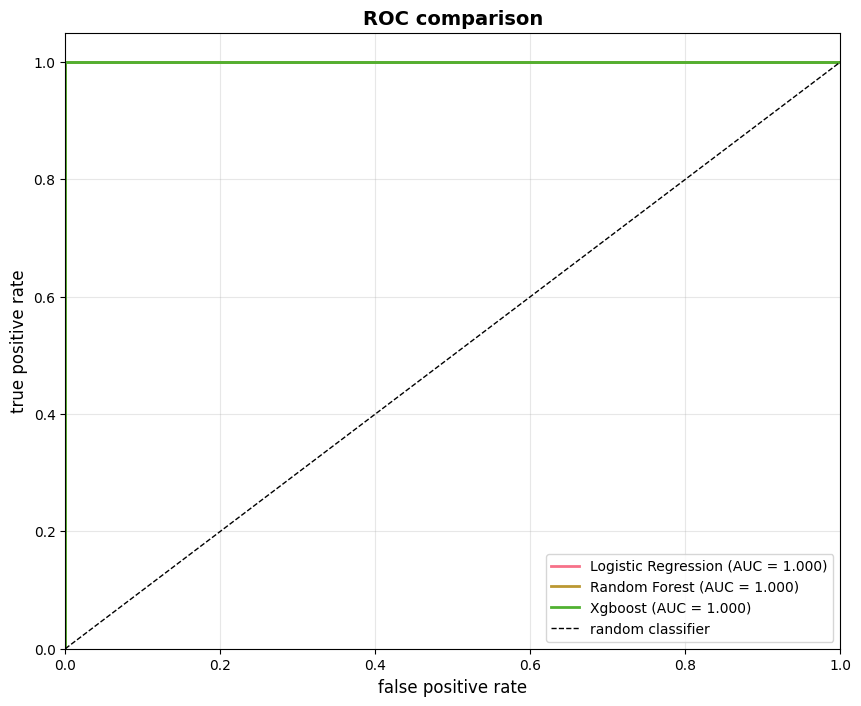

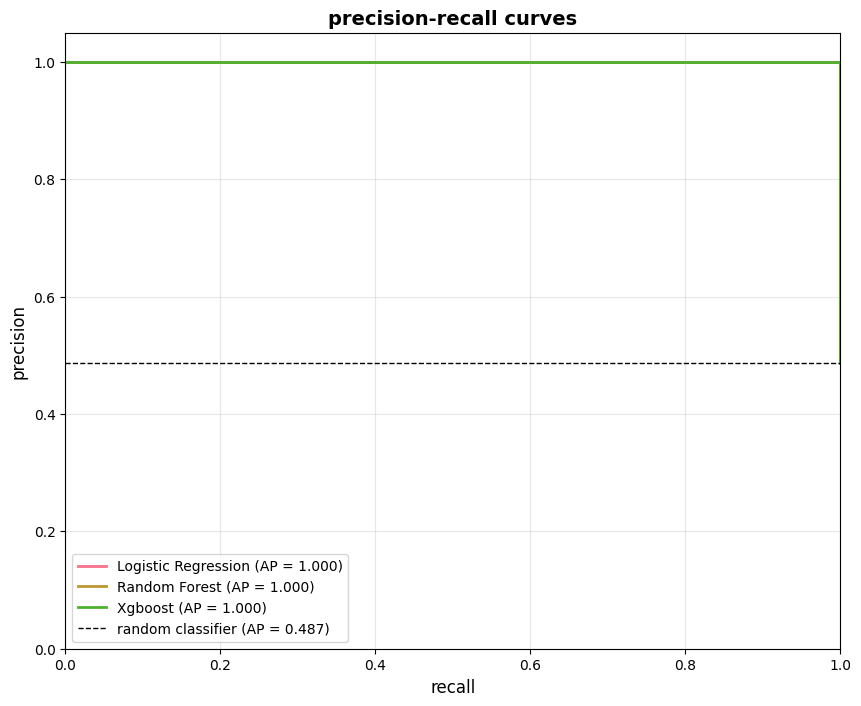

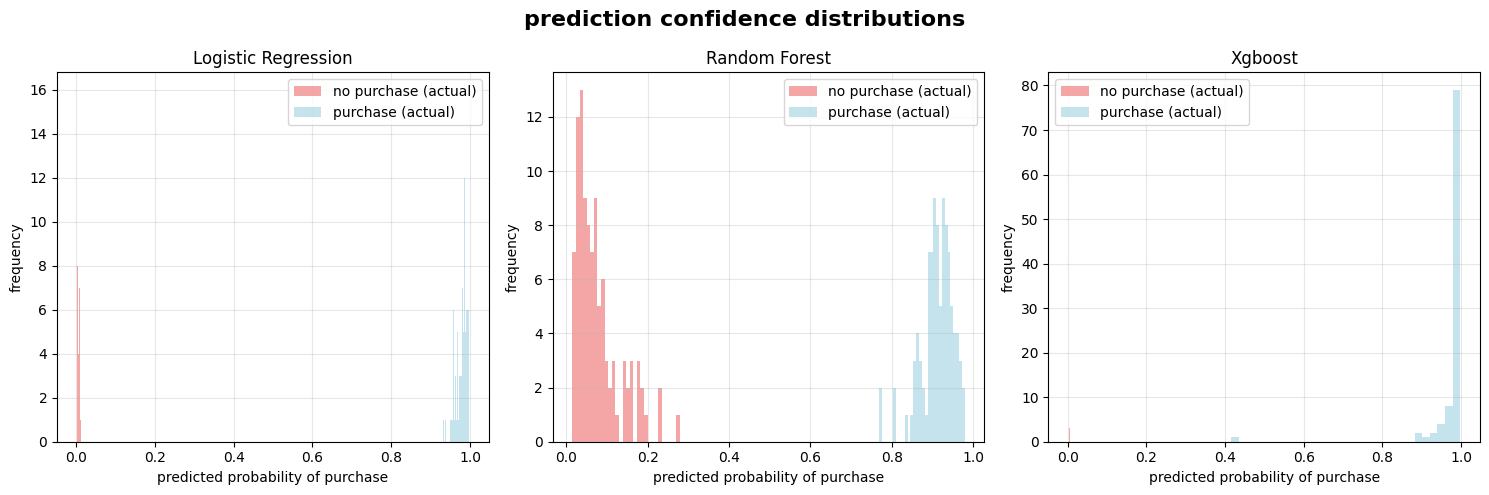


MODEL EVALUATION REPORT

1. PERFORMANCE METRICS COMPARISON
--------------------------------------------------
              model  accuracy  precision  recall  f1-score  ROC-AUC  PR-AUC
logistic_regression     1.000        1.0  1.0000    1.0000      1.0     1.0
      random_forest     1.000        1.0  1.0000    1.0000      1.0     1.0
            xgboost     0.995        1.0  0.9897    0.9948      1.0     1.0

2. BEST MODEL BY METRIC
--------------------------------------------------
accuracy    : logistic_regression (1.0000)
precision   : logistic_regression (1.0000)
recall      : logistic_regression (1.0000)
f1-score    : logistic_regression (1.0000)
ROC-AUC     : logistic_regression (1.0000)
PR-AUC      : xgboost         (1.0000)

3. CROSS-VALIDATION RESULTS (5-FOLD)
--------------------------------------------------

Logistic Regression:
  accuracy: 0.9929 (±0.0076)
  f1-score: 0.9929 (±0.0076)
  ROC-AUC:  0.9953 (±0.0068)

Random Forest:
  accuracy: 0.9929 (±0.0076)
  f1-score: 

In [41]:
feature_names = [
    'is_amazon_user',
    'num_events',
    'num_event_types',
    'num_domains',
    'range_active_days',
    'num_dates_active',
    'prop_top_domains',
    'prop_rare_domains',
    'prop_search_events',
    # 'gender_1',
    'gender_2',
    'gender_3',
    'gender_4',
    # 'age_group_1',
    'age_group_2',
    'age_group_3',
    'age_group_4',
    # 'age_group_5',
    # 'age_group_6',
    # 'age_group_7',
]

# Initialize evaluator
evaluator = ModelEvaluator(
    models=pipeline.models,  # Your trained models
    X_train=X_train,
    X_test=X_test, 
    y_train=y_train,
    y_test=y_test,
    feature_names=feature_names
)

# Run complete evaluation
results_df = evaluator.run_complete_evaluation()


In [42]:
with duckdb.connect(DATABASE_FILEPATH) as con:
    df=(
        con.sql("SELECT * FROM training_data_only_users")
        .df()
        .drop(
            columns=[
                'user_id',                     ## this field should have no bearing on the outcome
                'is_amazon_user',              ## uniformly TRUE
                'num_apps',                    ## uniformly 1
                'num_countries',               ## uniformly 1
                'country',                     ## uniformly 'US'
                'num_genders',                 ## uniformly 1
                'num_age_groups',              ## uniformly 1
                'earliest_event',              ## not using datetime fields at present
                'latest_event',                ## not using datetime fields at present
                'all_searches_combined',       ## not using nlp fields at present
                'num_successful_orders',       ## an outcome field for regression models, later
                'total_spend',                 ## an outcome field for regression models, later
                'num_categories_purchased',    ## an outcome field for regression models, later
                'num_subcategories_purchased', ## an outcome field for regression models, later
                'num_brands_purchased'         ## an outcome field for regression models, later
            ]
        )
    )

In [43]:
df.columns

Index(['num_events', 'num_event_types', 'num_domains', 'range_active_days',
       'num_dates_active', 'prop_top_domains', 'prop_rare_domains',
       'prop_search_events', 'gender', 'age_group', 'is_purchaser'],
      dtype='object')

STARTING TRAINING PIPELINE
numerical features: ['num_events', 'num_event_types', 'num_domains', 'range_active_days', 'num_dates_active']
categorical features: ['gender', 'age_group']

shape of training data: (394, 13)
shape of test data: (99, 13)
number of features after preprocessing: 13

LOGISTIC REGRESSION
✓ logistic regression model trained

RANDOM FOREST
✓ random forest model trained

XGBOOST
✓ XGBoost model trained

ALL MODELS TRAINED
models available: ['logistic_regression', 'random_forest', 'xgboost']

FEATURE IMPORTANCE ANALYSIS

RANDOM_FOREST - most important features:


,feature,importance
2,num_domains,0.280554
0,num_events,0.231181
5,gender_male,0.148563
4,num_dates_active,0.083585
9,age_group_35_44,0.071124



XGBOOST - most important features:


,feature,importance
5,gender_male,0.663843
8,age_group_25_34,0.136968
0,num_events,0.077081
4,num_dates_active,0.066337
2,num_domains,0.055770


STARTING MODEL EVALUATION
INFERRING PREDICTIONS FROM ALL MODELS
✓ inferred predictions for logistic_regression
✓ inferred predictions for random_forest
✓ inferred predictions for xgboost
predictions generated

PERFORMANCE METRICS
all metrics calculated

CROSS-VALIDATION
logistic_regression:
  accuracy: 0.7973 (±0.0505)
  f1-Score: 0.8855 (±0.0308)
  ROC-AUC:  0.5763 (±0.2956)
random_forest:
  accuracy: 0.9858 (±0.0049)
  f1-Score: 0.9929 (±0.0025)
  ROC-AUC:  0.8330 (±0.0959)
xgboost:
  accuracy: 0.7665 (±0.0734)
  f1-Score: 0.8655 (±0.0453)
  ROC-AUC:  0.6003 (±0.1210)
VISUALIZATION PLOTS


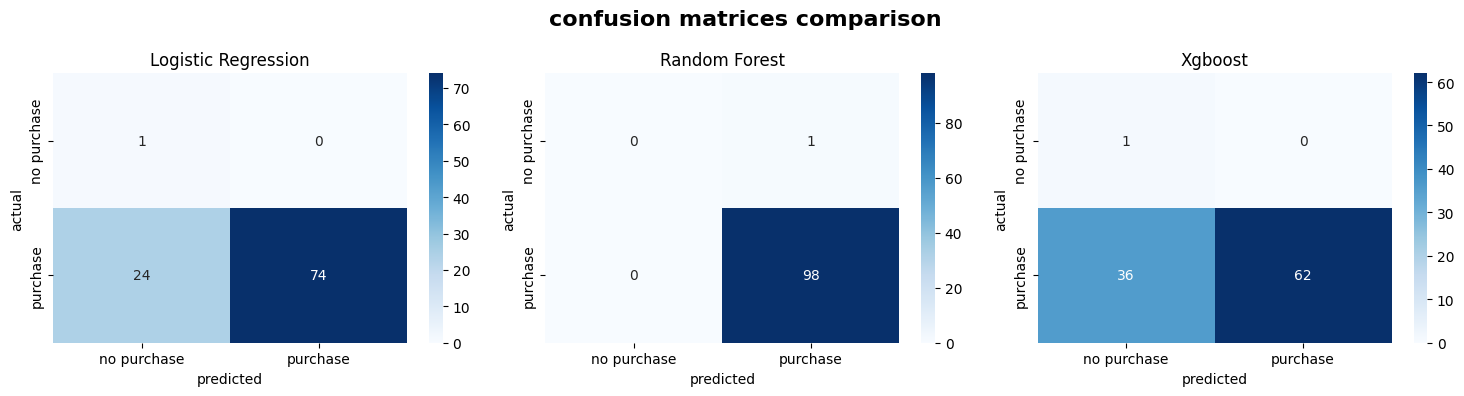

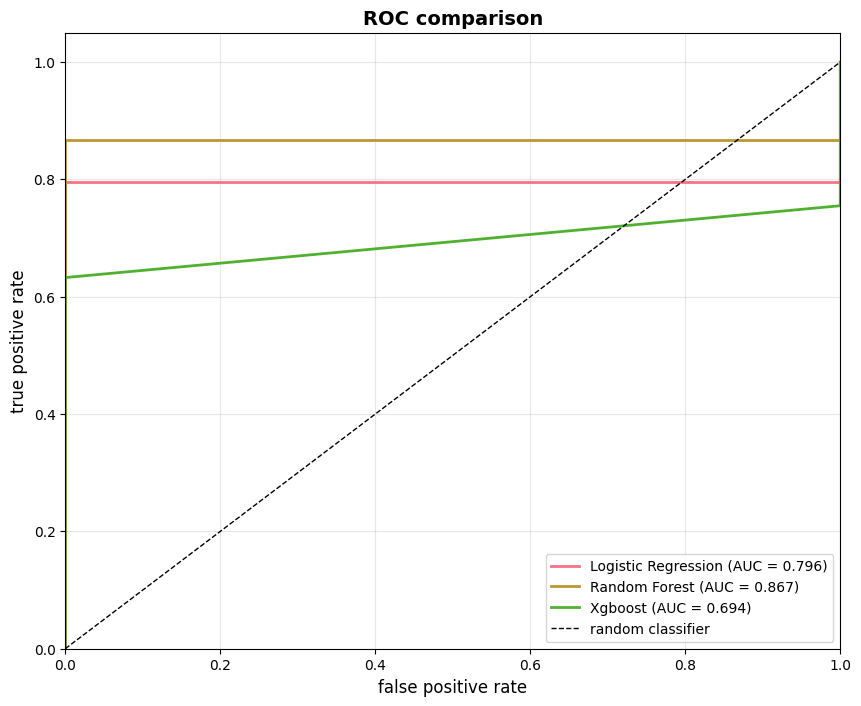

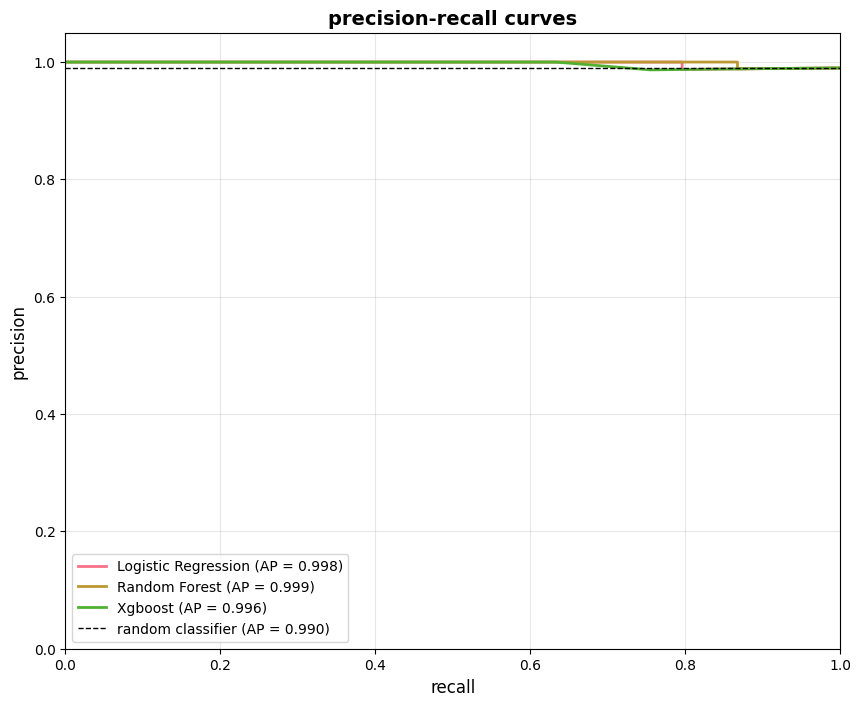

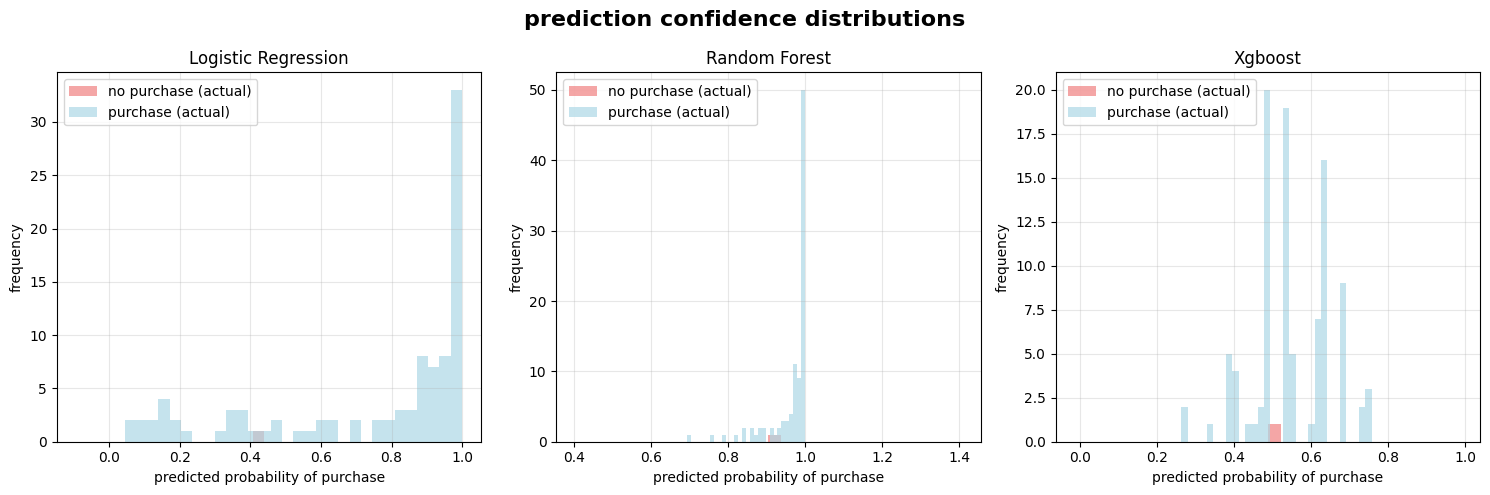


MODEL EVALUATION REPORT

1. PERFORMANCE METRICS COMPARISON
--------------------------------------------------
              model  accuracy  precision  recall  f1-score  ROC-AUC  PR-AUC
logistic_regression    0.7576     1.0000  0.7551    0.8605   0.7959  0.9977
      random_forest    0.9899     0.9899  1.0000    0.9949   0.8673  0.9986
            xgboost    0.6364     1.0000  0.6327    0.7750   0.6939  0.9956

2. BEST MODEL BY METRIC
--------------------------------------------------
accuracy    : random_forest   (0.9899)
precision   : logistic_regression (1.0000)
recall      : random_forest   (1.0000)
f1-score    : random_forest   (0.9949)
ROC-AUC     : random_forest   (0.8673)
PR-AUC      : random_forest   (0.9986)

3. CROSS-VALIDATION RESULTS (5-FOLD)
--------------------------------------------------

Logistic Regression:
  accuracy: 0.7973 (±0.0505)
  f1-score: 0.8855 (±0.0308)
  ROC-AUC:  0.5763 (±0.2956)

Random Forest:
  accuracy: 0.9858 (±0.0049)
  f1-score: 0.9929 (±0.0025)

In [44]:
# initialize pipeline process
pipeline = PurchasePredictionPipeline()
# run pipeline
X_train, X_test, y_train, y_test = pipeline.train_all_models(df)

# display feature importance for tree-based models
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

for model_name in ['random_forest', 'xgboost']:
    print(f"\n{model_name.upper()} - most important features:")
    importance_df = pipeline.get_feature_importance(model_name)
    if importance_df is not None:
        display(importance_df.head(5))



# initialize evaluator
evaluator = ModelEvaluator(
    models=pipeline.models,  
    X_train=X_train,
    X_test=X_test, 
    y_train=y_train,
    y_test=y_test,
    feature_names=None  # <--- infer feature names
)

# run evaluation
results_df = evaluator.run_complete_evaluation()